# HSCT survival: Cox proportional hazards model

## Notebook set-up

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
from sklearn.model_selection import train_test_split

import configuration as config

pd.set_option('display.max_rows', 500)

# Data files
data_df_file=f'{config.DATA_PATH}/processed/02.1-no_multicollinearity_encoded_all_imputed_data_df.parquet'
raw_data_file=f'{config.DATA_PATH}/raw/train.csv'
feature_types_dict_file=f'{config.DATA_PATH}/processed/01.1-feature_type_dict.pkl'

## 1. Load data

Feature types:

True numerical features
['donor_age', 'age_at_hct', 'year_hct', 'efs_time']

Ordinal features
['hla_match_c_high', 'hla_high_res_8', 'hla_low_res_6', 'hla_high_res_6', 'hla_high_res_10', 'hla_match_dqb1_high', 'hla_nmdp_6', 'hla_match_c_low', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'hla_match_a_high', 'hla_match_b_low', 'hla_match_a_low', 'hla_match_b_high', 'comorbidity_score', 'karnofsky_score', 'hla_low_res_8', 'hla_match_drb1_high', 'hla_low_res_10', 'dri_score', 'cyto_score', 'cmv_status', 'cyto_score_detail']

True categorical features
['psych_disturb', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'tce_imm_match', 'rituximab', 'prod_type', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan

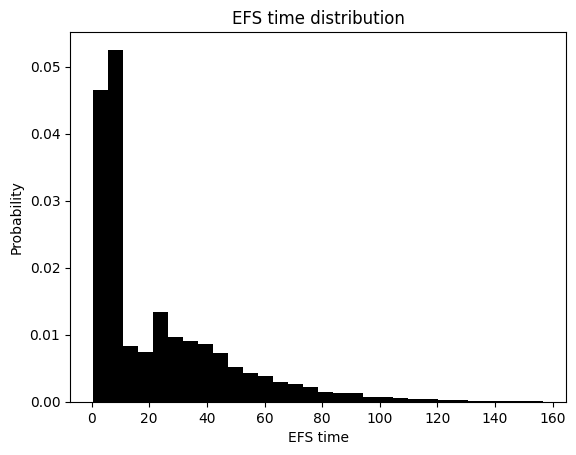

Training features: (28800, 118)


In [2]:
# Load the data
data_df=pd.read_parquet(data_df_file)

# Load and preserve race group for scoring
raw_data=pd.read_csv(raw_data_file)
data_df['race_group']=raw_data['race_group']

with open(feature_types_dict_file, 'rb') as input_file:
    feature_types_dict=pickle.load(input_file)
    
# Load feature type definitions
print('Feature types:\n')
for feature_type, features in feature_types_dict.items():
    print(f'{feature_type}\n{features}\n')

# Take a quick look at the target
plt.title('EFS time distribution')
plt.hist(data_df['efs_time'], density=True, bins=30, color='black')
plt.xlabel('EFS time')
plt.ylabel('Probability')
plt.show()

print(f'Training features: {data_df.shape}')

## 2. Data preparation

### 2.1 Train-test split

In [3]:
training, testing=train_test_split(data_df, test_size=0.33, random_state=315)

training_df=pd.DataFrame(training, columns=data_df.columns)
testing_df=pd.DataFrame(testing, columns=data_df.columns)

training_labels_df=training_df[['efs', 'efs_time']]
training_features_df=training_df.drop(['efs', 'efs_time'], axis=1)

testing_labels_df=testing_df[['efs', 'efs_time']]
testing_features_df=testing_df.drop(['efs', 'efs_time'], axis=1)

### 2.2. Save and remove training & testing race group

In [4]:
training_race_group=training_df['race_group']
testing_race_group=testing_df['race_group']

training_df.drop('race_group', axis=1, inplace=True)
testing_df.drop('race_group', axis=1, inplace=True)

### 2.3. Drop low entropy column

In [5]:
# training_df.drop('gvhd_proph_FK+- others(not MMF,MTX)', axis=1, inplace=True)
# testing_df.drop('gvhd_proph_FK+- others(not MMF,MTX)', axis=1, inplace=True)

### 2.4. Set-up stratification by binary one-hot encoded variables

In [6]:
# one_hot_features=[x for x in training_df.columns if x not in feature_types_dict['True numerical features']]
# one_hot_features.remove('efs')
# level_counts=training_df[one_hot_features].nunique()

# binary_features=level_counts[level_counts == 2].index.to_list()
# binary_features

## 3. Cox proportional hazards model

### 3.1. Naive model

In [7]:
cph_model=CoxPHFitter()
cph_model.fit(training_df, duration_col='efs_time', event_col='efs')

/mnt/arkk/kaggle/HSCT_survival/.venv/lib/python3.10/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['gvhd_proph_FK+- others(not MMF,MTX)'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


<lifelines.CoxPHFitter: fitted with 19296 total observations, 8876 right-censored observations>

### 3.2. Drop low entropy feature

In [8]:
training_df.drop('gvhd_proph_FK+- others(not MMF,MTX)', axis=1, inplace=True)
testing_df.drop('gvhd_proph_FK+- others(not MMF,MTX)', axis=1, inplace=True)

cph_model=CoxPHFitter()
cph_model.fit(training_df, duration_col='efs_time', event_col='efs')

<lifelines.CoxPHFitter: fitted with 19296 total observations, 8876 right-censored observations>

### 3.3. Select featured with p < 0.001

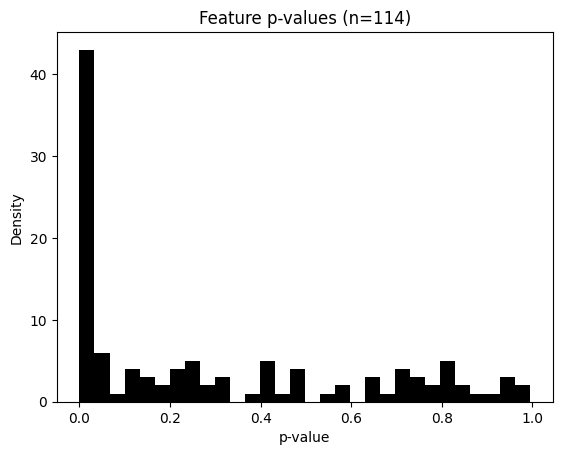

Significant features at alpha = 0.05: 45
Significant features at alpha = 0.001: 25


In [9]:
feature_pvals=cph_model.summary['p']

plt.title(f'Feature p-values (n={len(feature_pvals)})')
plt.hist(feature_pvals, color='black', bins=30)
plt.xlabel('p-value')
plt.ylabel('Density')
plt.show()

significant_features=feature_pvals[feature_pvals < 0.05]
print(f'Significant features at alpha = 0.05: {len(significant_features)}')

significant_features=feature_pvals[feature_pvals < 0.001]
print(f'Significant features at alpha = 0.001: {len(significant_features)}')

In [10]:
training_significant_features_df=training_df[feature_pvals[feature_pvals < 0.001].index].copy()
testing_significant_features_df=testing_df[feature_pvals[feature_pvals < 0.001].index].copy()

training_significant_features_df['efs']=training_df['efs']
training_significant_features_df['efs_time']=training_df['efs_time']
testing_significant_features_df['efs']=testing_df['efs']
testing_significant_features_df['efs_time']=testing_df['efs_time']

cph_model=CoxPHFitter()
cph_model.fit(training_significant_features_df, duration_col='efs_time', event_col='efs')
cph_model.print_summary()

<lifelines.CoxPHFitter: fitted with 19296 total observations, 8876 right-censored observations>
             duration col = 'efs_time'
                event col = 'efs'
      baseline estimation = breslow
   number of observations = 19296
number of events observed = 10420
   partial log-likelihood = -97568.49
         time fit was run = 2025-02-13 14:44:27 UTC

---
                                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                             
comorbidity_score                     0.07      1.07      0.01            0.06            0.08                1.06                1.08
karnofsky_score                      -0.01      0.99      0.00           -0.01           -0.01                0.99                0.99
hla_match_drb1_high                   0.16      1.17      0.02            0.11            0.21                1.12                1.23
dri_score                             0.12      1.12      0.01            0.10            0.13                1.11                1.14
cyto_score                            0.06      1.06      0.01            0.04            0.08                1.04                1.08
cyto_score_detail                     0.22      1.25      0.01            0.20            0.25                1.22                1.28
age_at_hct                            0.00      1.00      0.00            0.00            0.00                1.00                1.00
year_hct                             -0.04      0.96      0.00           -0.05           -0.03                0.96                0.97
diabetes_Yes                          0.15      1.16      0.03            0.10            0.20                1.10                1.22
tbi_status_TBI + Cy +- Other          0.16      1.18      0.03            0.11            0.21                1.12                1.24
tbi_status_TBI +- Other, <=cGy        0.23      1.26      0.04            0.15            0.30                1.17                1.36
pulm_severe_Yes                       0.22      1.25      0.04            0.15            0.30                1.16                1.35
prim_disease_hct_HIS                 -1.13      0.32      0.15           -1.42           -0.84                0.24                0.43
prim_disease_hct_IEA                 -0.69      0.50      0.07           -0.83           -0.56                0.44                0.57
prim_disease_hct_IIS                 -0.96      0.38      0.09           -1.14           -0.78                0.32                0.46
prim_disease_hct_PCD                 -0.45      0.64      0.07           -0.59           -0.31                0.55                0.73
prim_disease_hct_SAA                 -0.36      0.70      0.08           -0.51           -0.20                0.60                0.82
conditioning_intensity_RIC            0.16      1.18      0.02            0.12            0.21                1.13                1.23
mrd_hct_Positive                     -0.06      0.94      0.02           -0.11           -0.01                0.90                0.99
in_vivo_tcd_Yes                      -0.14      0.87      0.02           -0.18           -0.09                0.83                0.91
hepatic_severe_Yes                   -0.26      0.77      0.05           -0.36           -0.15                0.69                0.86
sex_match_F-M                         0.27      1.31      0.02            0.23            0.32                1.26                1.38
sex_match_M-F                         0.24      1.27      0.02            0.19            0.28                1.21                1.33
race_group_Black or African-American  0.17      1.18      0.03            0.11            0.22                1.12                1.24
cardiac_Yes                           0.26      1.30      0.04            0.18            0.33                1.20        

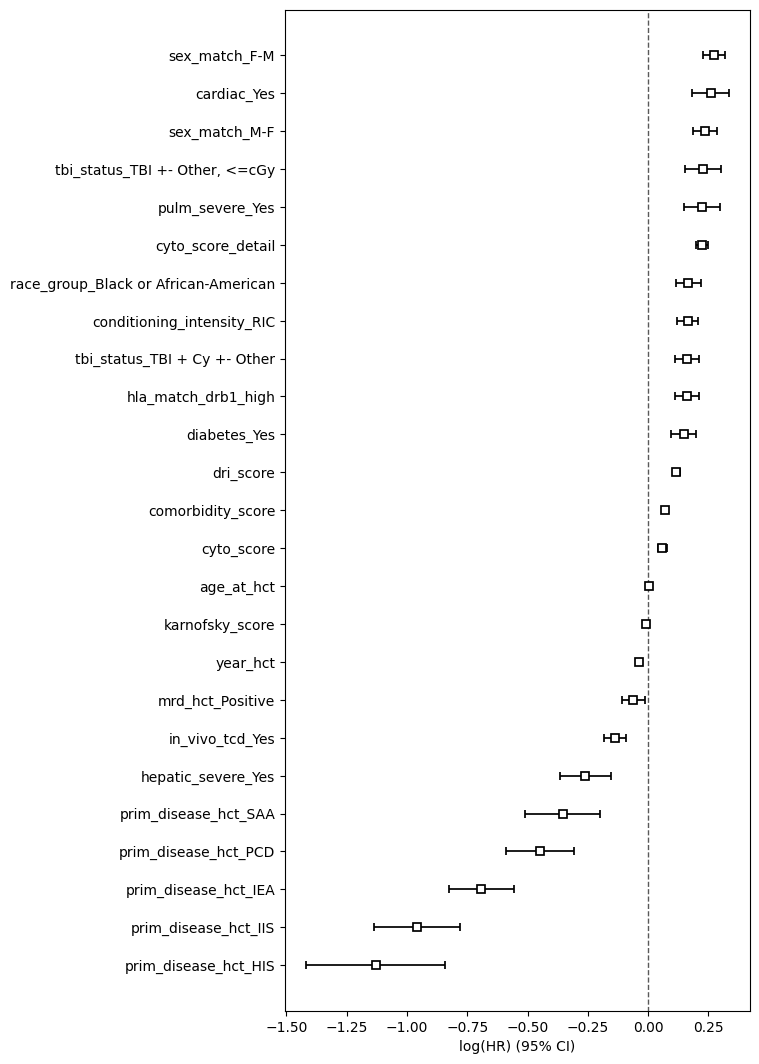

In [11]:
fig=plt.figure(figsize=[6,13])
cph_model.plot(figure=fig)
plt.show()

In [ ]:
cph_model.check_assumptions(training_significant_features_df, p_value_threshold=0.05, show_plots=True)


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 19296 total observations, 8876 right-censored observations>
         test_name = proportional_hazard_test

---
                                           test_statistic      p  -log2(p)
age_at_hct                           km             79.94 <0.005     61.17
                                     rank           80.01 <0.005     61.22
cardiac_Yes                          km              2.57   0.11      3.20
                                     rank            2.56   0.11      3.19
comorbidity_score                    km             88.46 <0.005     67.38
                                     rank           88.49 <0.005     67.41
conditioning_intensity_RIC           km              9.31 <0.005      8.78
                                     rank            9.29 <0.005      8.76
cyto_score                           km             45.67 <0.005     36.05
                                     rank           45.66 <0.005     36.05
cyto_score_detail                    km             92.26 <0.005     70.16
                                     rank           92.20 <0.005     70.11
diabetes_Yes                         km              1.64   0.20      2.32
                                     rank            1.64   0.20      2.32
dri_score                            km             34.33 <0.005     27.68
                                     rank           34.35 <0.005     27.69
hepatic_severe_Yes                   km             14.58 <0.005     12.86
                                     rank           14.60 <0.005     12.88
hla_match_drb1_high                  km            125.48 <0.005     94.34
                                     rank          125.51 <0.005     94.36
in_vivo_tcd_Yes                      km            284.73 <0.005    209.80
                                     rank          284.60 <0.005    209.70
karnofsky_score                      km            173.08 <0.005    128.91
                                     rank          173.13 <0.005    128.94
mrd_hct_Positive                     km              2.13   0.14      2.79
                                     rank            2.13   0.14      2.79
prim_disease_hct_HIS                 km              6.55   0.01      6.57
                                     rank            6.55   0.01      6.57
prim_disease_hct_IEA                 km             10.51 <0.005      9.72
                                     rank           10.53 <0.005      9.73
prim_disease_hct_IIS                 km              4.87   0.03      5.20
                                     rank            4.88   0.03      5.20
prim_disease_hct_PCD                 km             10.27 <0.005      9.53
                                     rank           10.28 <0.005      9.54
prim_disease_hct_SAA                 km             10.42 <0.005      9.65
                                     rank           10.44 <0.005      9.66
pulm_severe_Yes                      km              0.87   0.35      1.51
                                     rank            0.88   0.35      1.52
race_group_Black or African-American km              2.10   0.15      2.77
                                     rank            2.10   0.15      2.76
sex_match_F-M                        km              8.14 <0.005      7.85
                                     rank            8.14 <0.005      7.85
sex_match_M-F                        km              0.83   0.36      1.46
                                     rank            0.83   0.36      1.46
tbi_status_TBI + Cy +- Other         km              0.16   0.69      0.54
                                     rank            0.16   0.69      0.53
tbi_status_TBI +- Other, <=cGy       km              0.00   0.97      0.05
                                     rank            0.00   0.97      0.05
year_hct                             km      



1. Variable 'comorbidity_score' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'comorbidity_score' might be incorrect. That is,
there may be non-linear terms missing. The proportional hazard test used is very sensitive to
incorrect functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'comorbidity_score' using pd.cut, and then specify it in
`strata=['comorbidity_score', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


2. Variable 'karnofsky_score' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'karnofsky_score' might be incorrect. That is,
there may be non-linear terms missing. The proportional hazard test used is very sen

## 4. Test set predictions

### 4.1. Survival curve forecasts

In [ ]:
# Note: looped point predictions take about 20 seconds per
# patient for 160 time points, and it does run on all cores

testing_survival_curves=[]

# for _, row in testing_features_df.iterrows():
for i in range(5):

    predictions=[]

    for j in range(1,160):

        prediction=result.predict(
            exog=testing_features_df.iloc[i],
            endog=np.array([[j]]).astype(int),
            pred_type='surv'
        )

        predictions.append(prediction.predicted_values)

    testing_survival_curves.append(predictions)

In [ ]:
plt.title('Test set: predicted survival curves')

for i, survival_curve in enumerate(testing_survival_curves):
    plt.plot(list(range(1,160)), survival_curve, label=i)

plt.xlabel('Weeks since HCT')
plt.ylabel('Survival probability')
plt.xscale('log')
plt.legend(loc='upper right')
plt.show()

### 4.2. Cumulative hazard forecasts

In [ ]:
# Note: looped point predictions take about 20 seconds per
# patient for 160 time points, and it does run on all cores

testing_survival_curves=[]

# for _, row in testing_features_df.iterrows():
for i in range(5):

    predictions=[]

    for j in range(1,160):

        prediction=result.predict(
            exog=testing_features_df.iloc[i],
            endog=np.array([[j]]),
            pred_type='cumhaz'
        )

        predictions.append(prediction.predicted_values)

    testing_survival_curves.append(predictions)

In [ ]:
plt.title('Test set: predicted cumulative hazard curves')

for i, survival_curve in enumerate(testing_survival_curves):
    plt.plot(list(range(1,160)), survival_curve, label=i)

plt.xlabel('Weeks since HCT')
plt.ylabel('Cumulative hazard')
plt.xscale('log')
plt.legend(loc='upper right')
plt.show()

### 4.2. Survival function forecasts: 20 weeks

In [ ]:
survival_function_values=[]
sample_testing_features_df=testing_features.iloc[:1000]

for _, row in sample_testing_features_df.iterrows():

    prediction=result.predict(
        exog=row,
        endog=np.array([[20]]),
        pred_type='surv'
    )

    survival_function_values.append(prediction.predicted_values)

In [ ]:
sample_testing_labels_df=testing_labels_df.iloc[:1000].copy()
sample_testing_labels_df['Survival probability']=survival_function_values

efs_positive_df=sample_testing_labels_df[sample_testing_labels_df['efs'] == 1]
efs_negative_df=sample_testing_labels_df[sample_testing_labels_df['efs'] == 0]

plt.title('Survival probability vs EFS time')
plt.scatter(efs_positive_df['efs_time'], efs_positive_df['Survival probability'], color='firebrick', label='EFS 1')
plt.scatter(efs_negative_df['efs_time'], efs_negative_df['Survival probability'], color='black', label='EFS 0')
plt.xlabel('True EFS time')
plt.ylabel('Probability of survival at 20 weeks')
plt.show()

## 5. Survival function estimate at EFS time

In [ ]:
survival_function_values=[]

for i in range(1000):

    feature_row=training_features_df.iloc[i]
    label_row=training_labels_df.iloc[i]

    prediction=result.predict(
        exog=feature_row,
        endog=np.array([[label_row['efs_time']]]),
        pred_type='surv'
    )

    survival_function_values.extend(prediction.predicted_values)

survival_function_estimate=training_labels_df.iloc[:1000].copy()
survival_function_estimate['survival_function']=survival_function_values

efs_negative=survival_function_estimate[survival_function_estimate['efs'] == 0]
efs_positive=survival_function_estimate[survival_function_estimate['efs'] == 1]

In [ ]:
plt.title('Survival function at EFS time')
plt.scatter(efs_negative['efs_time'], efs_negative['survival_function'], color='black', label='EFS 0')
plt.scatter(efs_positive['efs_time'], efs_positive['survival_function'], color='firebrick', label='EFS 1')
plt.xlabel('True EFS time')
plt.ylabel('Survival function estimate')
plt.show()